In [ ]:
import pandas as pd
import numpy as np
import re
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_score

df = pd.read_csv("merged_clean(last_version).csv", sep=";")

df = df.dropna(subset=["metascore", "user_score", "platforms_parsed", "genres_parsed"])# Удаляем строки с пропусками в наиболее важных столбцах
df = df.reset_index(drop=True)# Возвращаем правильные индексы

df["rating_parsed"] = df["rating_parsed"].fillna("Unknown")# Заполняем NaN значением Unknown в столбце с возрастным рейтингом

df["num_platforms"] = df["platforms_parsed"].apply(lambda x: len(x.split(',')) if pd.notnull(x) else 0)# Добавляю столбец с количеством поддерживаемых платформ

# **9.Гипотеза о влиянии критиков**

Metascore является сильным предиктором пользовательской оценки

R^2 для регрессии user_score - metascore: 0.31308060257902237
Корреляция Пирсона между metascore и user_score: 0.5595360601239405


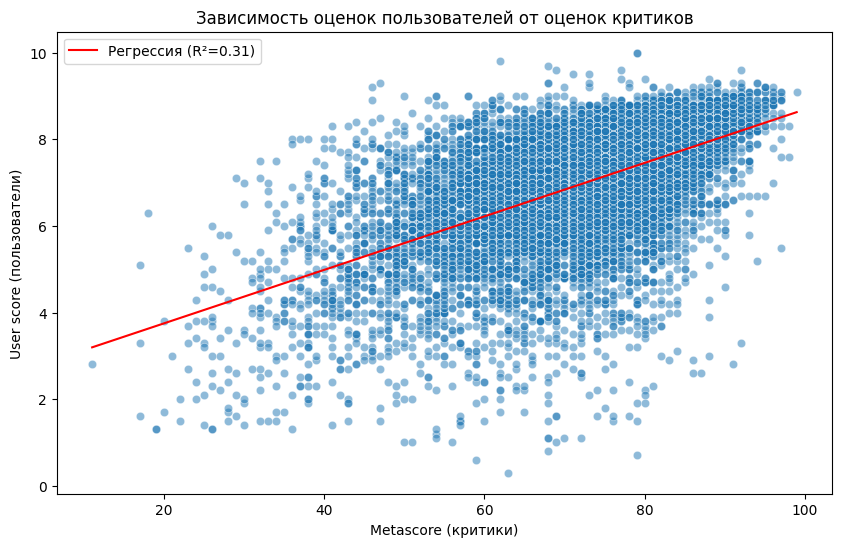

In [ ]:
X = df[["metascore"]].values# Предсказывающие величины
y = df["user_score"].values# Целевые величины

model = LinearRegression()# Создаём модель линейной регрессии
model.fit(X, y)# На основе рейтинга критиков и рейтинга пользователей обучаем модель
y_pred = model.predict(X)# При помощи обученной модели считаем предсказанную оценку пользователя

r2 = r2_score(y, y_pred)# Находим R^2-сравниваем реальные оценки пользователей с предсказанными
print("R^2 для регрессии user_score - metascore:", r2)

correlation = df["metascore"].corr(df["user_score"])# Находим корреляцию Пирсона
print("Корреляция Пирсона между metascore и user_score:", correlation)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=df["metascore"], y=df["user_score"], alpha=0.5)#Строим график зависимости пользовательских оценок от оценок критиков
plt.plot(df["metascore"], y_pred, color="red", label=f"Регрессия (R²={r2:.2f})")#Линия регрессии
plt.xlabel("Metascore (критики)")
plt.ylabel("User score (пользователи)")
plt.title("Зависимость оценок пользователей от оценок критиков")
plt.legend()
plt.show()

Гипотеза частично подтверждена: Средняя зависимость между оценкой критиков и пользователей есть, однако присутсвуют другие влияющие факторы (хайп вокруг игры, цена, баги и тд)

# **10.Гипотеза о рыночных нишах**

Можно выделить кластеры игр с одинаковыми паттернами по жанрам, платформам и рейтингам (например, “инди-инновации”, “массовые ААА-шутеры”).

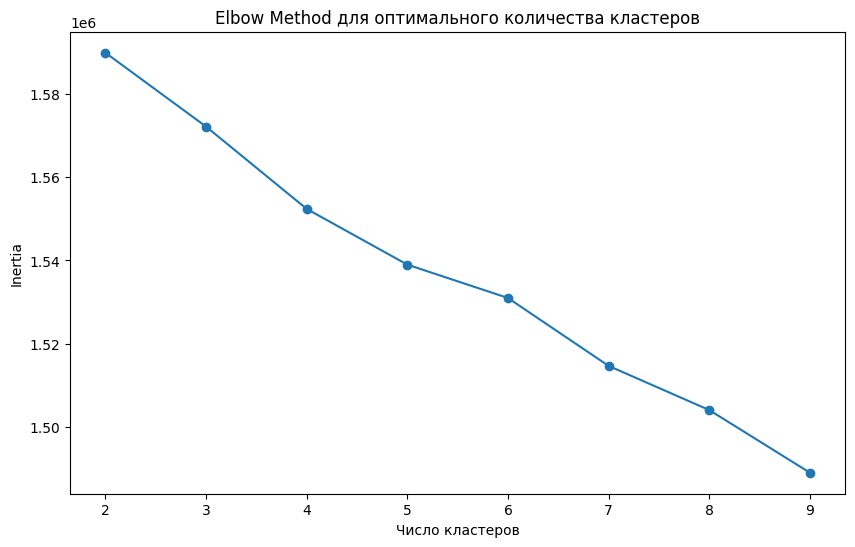

Оптимальное K по Silhouette: 4 (score: -0.0052)


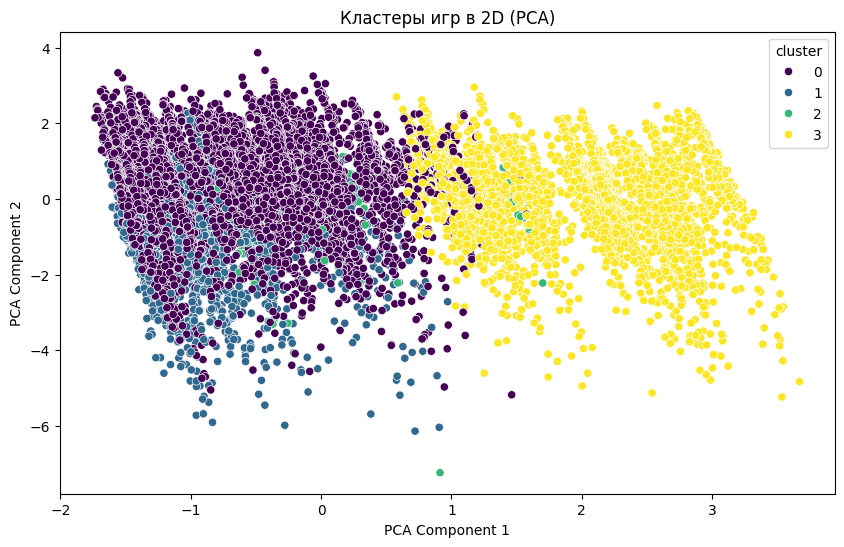

Описание кластеров:
         metascore  user_score  num_platforms  genres_parsed rating_parsed  \
cluster                                                                      
0        71.869339    6.916169       2.932550            FPS             M   
1        70.947440    6.992577       2.580872     Action RPG             T   
2        69.546154    6.796154       2.046154       Strategy       Unknown   
3        71.469830    6.879643       2.591974  2D Platformer             E   

         count  
cluster         
0         5189  
1         3691  
2          130  
3         3414  

Примеры игр из кластера 3:
['the legend of zelda ocarina of time' 'super mario galaxy'
 'super mario galaxy 2' 'super mario odyssey' 'nfl 2k1']

Примеры игр из кластера 1:
['soulcalibur' 'tony hawks pro skater 3' 'metroid prime' 'goldeneye 007'
 'uncharted 2 among thieves']

Примеры игр из кластера 0:
['grand theft auto iv' 'the legend of zelda breath of the wild'
 'perfect dark 2000' 'red dead redemption

In [ ]:
genres_encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore")# One-hot encoding для жанров игр
genres_encoded = genres_encoder.fit_transform(df[["genres_parsed"]])

rating_encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore")# One-hot encoding для возрастного рейтинга игр
rating_encoded = rating_encoder.fit_transform(df[["rating_parsed"]])

numeric_features = df[["metascore", "user_score", "num_platforms"]].values# Числовые признаки

features = np.hstack([numeric_features, genres_encoded, rating_encoded])# Объединение признаков

scaler = StandardScaler()# Нормализация признаков
features_scaled = scaler.fit_transform(features)

# Используем Elbow method
inertia = []# Список сумм квадратов расстояний до центров
sil_scores = []# Список оценок качества кластеров
k_range = range(2, 10)# Перебираем количество кластеров
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(features_scaled)
    inertia.append(kmeans.inertia_)# Суммы квадратов расстояний до центров добавляем в массив сумм
    sil_scores.append(silhouette_score(features_scaled, kmeans.labels_))# Оценку качества кластеров добавляем в соответсвующий список

plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, marker="o")# Строим график Elbow Method для нахождения оптимального числа кластеров
plt.xlabel("Число кластеров")
plt.ylabel("Inertia")
plt.title("Elbow Method для оптимального количества кластеров")
plt.show()

optimal_k = k_range[np.argmax(sil_scores)]# Оптимальное количество кластеров по Silhouette score
print(f"Оптимальное K по Silhouette: {optimal_k} (score: {max(sil_scores):.4f})")

kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)# Кластеризация
df["cluster"] = kmeans.fit_predict(features_scaled)

pca = PCA(n_components=2)# Визуализация с PCA
features_pca = pca.fit_transform(features_scaled)
plt.figure(figsize=(10, 6))
sns.scatterplot(x=features_pca[:, 0], y=features_pca[:, 1], hue=df["cluster"], palette="viridis")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("Кластеры игр в 2D (PCA)")
plt.show()

cluster_summary = df.groupby("cluster").agg({# Описание кластеров
    "metascore": "mean",
    "user_score": "mean",
    "num_platforms": "mean",
    "genres_parsed": lambda x: x.mode()[0] if not x.empty else "N/A",# Самый частый жанр игр
    "rating_parsed": lambda x: x.mode()[0] if not x.empty else "N/A",# Самый частый возрастной рейтинг игр
    "title": "count"
}).rename(columns={"title": "count"})
print("Описание кластеров:")
print(cluster_summary)

for cluster in df["cluster"].unique():# Примеры игр из кластеров
    print(f"\nПримеры игр из кластера {cluster}:")
    print(df[df["cluster"] == cluster]["title"].head(5).values)

Кластеризация выделила 4 группы при Silhouette score = -0.0052, что указывает на бессмысленные кластеры, хуже случайного деления. Все кластеры имеют почти идентичные характеристики:

Metascore: 69.5–71.9
User Score: 6.8–7.0
Платформы: 2.0–2.9

Жанры (FPS, Action RPG, Strategy, 2D Platformer) не соответствуют содержимому: в кластере «FPS» — GTA и Zelda, в «2D Platformer» — Mario и Ocarina of Time.

**Причины провала:**

Оценки не разделяют рынок — 95% игр в диапазоне 60–80.
Жанры пересекаются — one-hot кодирование создаёт шум.
Отсутствуют ключевые признаки: бюджет, продажи, разработчик.

**Вывод:**

Рынок игр не сегментируется по Metacritic, платформам и рейтингу. Настоящие ниши формируются бизнес-моделью, маркетингом и деньгами, а не оценками критиков. Кластеризация по текущим данным — бесполезна.